# Overview

- 2D trilateration with digital caliper (called "micrometer" in the past) locate location along pole face
- Also works away from pole, and X offset is added.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Imports

In [2]:
import numpy as np
import lmfit as lm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# %matplotlib inline
%matplotlib notebook

from plotting import config_plots
config_plots()

# 2D Triangulation (NMR Location)

- Note that coordinate system used here has the origin at the lower left hand corner of the square s.t. the circular pole face is inscribed
- y measurements (for the spacers) are offset by 25 mm, from the vertical 80/20 piece used to estimate spacer locations
- Measurements i=1,2,3 start at lower left spacer and goes around clockwise.
- Measure from "inside edge" (i.e. towards pole tip center) of brass. Right now, add "radius of brass" to your measurements -- everything should be w.r.t. brass center
    - In the future, maybe add this to the function so the user does not need to include it.

In [3]:
def loc2dist_2d(stations, **params):
    #x0 = params['x0']
    y0 = params['y0']
    z0 = params['z0']
    #test_point = np.array([[x0, y0, z0]])
    test_point = np.array([[y0, z0]])
    return np.linalg.norm(np.subtract(stations, test_point), axis=1)

def triangulate_GMW_2d_data(meas_dists, stations, noise_level=2, init_vals=[125.,125.]):
    model = lm.Model(loc2dist_2d, independent_vars=['stations'])
    params = lm.Parameters()
    params.add('y0', value=init_vals[0], vary=True, min=0., max=250.)
    params.add('z0', value=init_vals[1], vary=True, min=0., max=250.)
    result = model.fit(meas_dists, stations=stations, params=params,
                       weights=1/(noise_level*np.ones_like(meas_dists)),
                       method='least_squares')
    fit_point = np.array([result.params[f'{i}0'].value for i in ['y', 'z']])
    return fit_point, result

In [4]:
# GLOBALS
# These should never change, as long as the brass spacer locations never change
spacer_diameter = 19.33 # mm, measured with micrometer
y_offset = 25 # mm, width of 80/2, tape measure
#spacers = np.array([
# all station units mm
stations = np.array([
    [51. + spacer_diameter/2 - y_offset, 50.],
    [136. + spacer_diameter/2 - y_offset, 230. + spacer_diameter/2],
    [226. + spacer_diameter/2 - y_offset, 47.]
])

In [5]:
# an example measurement of the location of the NMR taped to the pole
meas_dists = np.array([109.75, 93.31, 117.57]) + spacer_diameter/2 # mm, measured with micrometer
# I also estimated the location "by hand" using a tape measure
nmr_tape_est = np.array([125., 136.])

In [6]:
meas_dists

array([119.415, 102.975, 127.235])

In [7]:
stations

array([[ 35.665,  50.   ],
       [120.665, 239.665],
       [210.665,  47.   ]])

In [8]:
params = {'y0':125., 'z0':125.}

In [9]:
loc2dist_2d(stations, **params)

array([116.64365489, 114.74691477, 115.85547991])

In [10]:
stations

array([[ 35.665,  50.   ],
       [120.665, 239.665],
       [210.665,  47.   ]])

In [11]:
meas_dists

array([119.415, 102.975, 127.235])

In [12]:
meas_dists

array([119.415, 102.975, 127.235])

05-25-22 13:18:23

- Measured location of NMR at middle of YZ range. Will use this to define the new "Zaber_Magnet_Convert.py" file.

In [13]:
meas_dists_x0 = np.array([113.44, 94.93, 111.58]) + spacer_diameter/2 # mm, measured with micrometer
meas_dists_xf = np.array([104.96, 99.09, 113.92]) + spacer_diameter/2 # mm, measured with micrometer

In [14]:
_ = triangulate_GMW_2d_data(meas_dists_x0, stations, noise_level=2, init_vals=[125.,125.])
nmr_best_fit_x0, result_x0 = _
_ = triangulate_GMW_2d_data(meas_dists_xf, stations, noise_level=2, init_vals=[125.,125.])
nmr_best_fit_xf, result_xf = _

In [15]:
result_x0

In [16]:
result_xf

In [17]:
# plot --> function
def make_pole_plot(stations, fig=None, ax=None):
    # assumes fixed parameters -- i.e. pole caps always 250 mm diameter
    # stations allowed to move. make a factory function so we can assume they don't?
    if fig is None:
        fig = plt.figure()
        ax = fig.add_axes((0.1, 0.1, 0.6, 0.8))
    # parameterize and plot pole face
    ts = np.linspace(0, 2*np.pi, 501)
    ys = 125. + 125.*np.cos(ts)
    zs = 125. + 125.*np.sin(ts)
    ax.fill(ys, zs, label='Pole Cap', color='gray', alpha=0.8, zorder=50)
    # parameterize and plot spacers
    for i, sta in enumerate(stations):
        y_ = sta[0] + spacer_diameter/2 * np.cos(ts)
        z_ = sta[1] + spacer_diameter/2 * np.sin(ts)
        l = None
        if i == 0:
            l = 'Brass Spacers'
        ax.fill(y_, z_, label=l, color='orange', zorder=51)
    # other configs
    ax.set_aspect('equal')
    ax.set_xlabel('y [mm]')
    ax.set_ylabel('z [mm]')
    ax.legend(fontsize=14, bbox_to_anchor=(0.99,1.0), loc="upper left").set_zorder(100)
    return fig, ax, ts

<IPython.core.display.Javascript object>


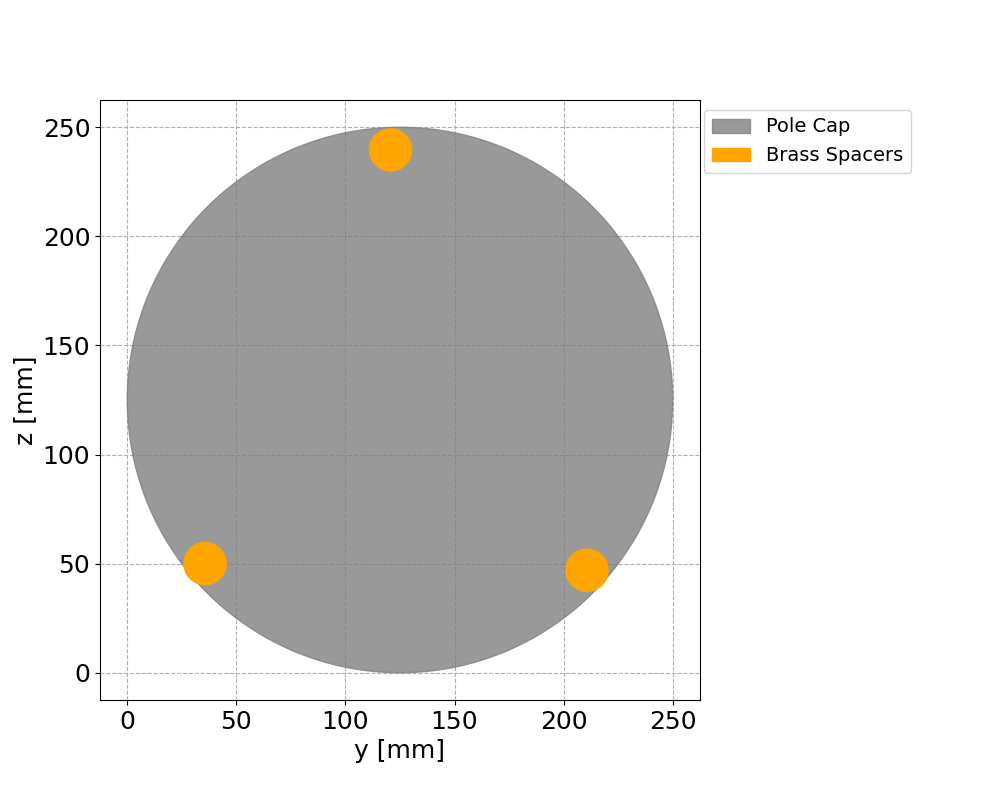

In [18]:
fig, ax, ts = make_pole_plot(stations)

<IPython.core.display.Javascript object>


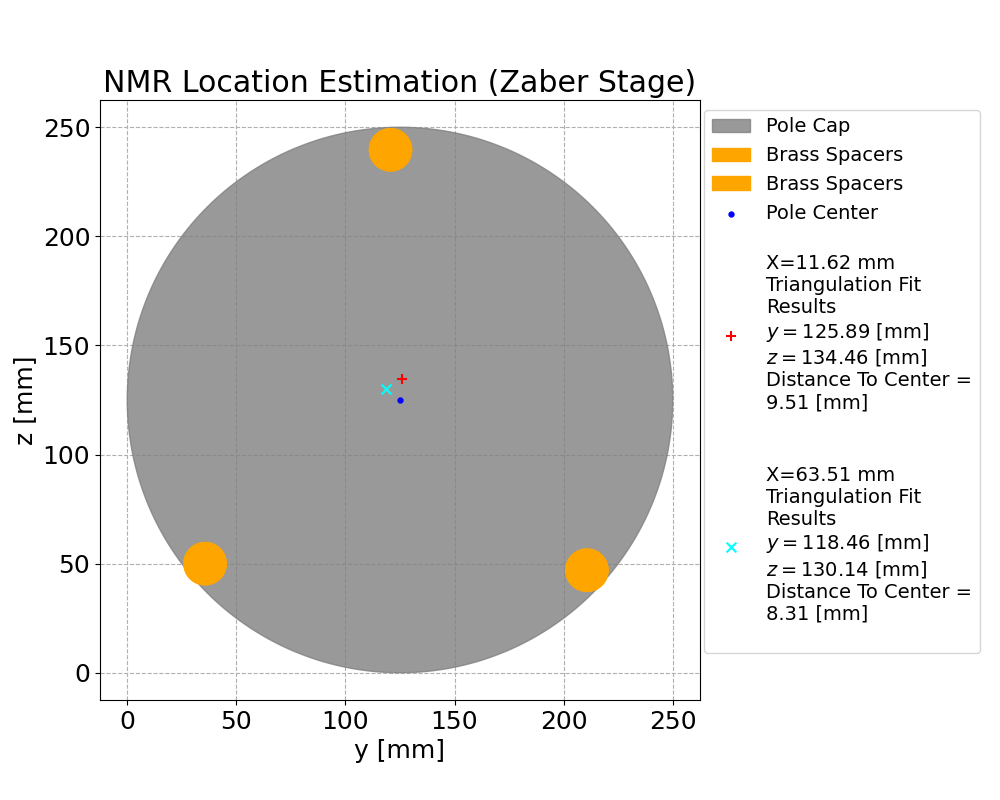

In [20]:
fig, ax, ts = make_pole_plot(stations)

#ax.plot(ys, zs, label='Pole Cap', zorder=50)
# ax.fill(ys, zs, label='Pole Cap', color='gray', alpha=0.8, zorder=50)

ax.scatter([125.], [125.], s=50, marker='.', color='blue', label='Pole Center', zorder=52)

for i, sta in enumerate(stations):
    y_ = sta[0] + spacer_diameter/2 * np.cos(ts)
    z_ = sta[1] + spacer_diameter/2 * np.sin(ts)
    l = None
    if i == 0:
        l = 'Brass Spacers'
    ax.fill(y_, z_, label=l, color='orange', zorder=51)
#ax.scatter(*stations.T, s=25, c='orange', label='Brass Spacers')
center = np.array([125., 125.])
d_xf = np.linalg.norm(nmr_best_fit_xf-center)
d_x0 = np.linalg.norm(nmr_best_fit_x0-center)

ax.scatter([nmr_best_fit_x0[0]], [nmr_best_fit_x0[1]], c='red', marker='+', s=50, zorder=53,
           label='\nX=11.62 mm\nTriangulation Fit\nResults\n'+rf'$y={nmr_best_fit_x0[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_best_fit_x0[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_x0:0.2f} [mm]\n')

ax.scatter([nmr_best_fit_xf[0]], [nmr_best_fit_xf[1]], c='cyan', marker='x', s=50, zorder=53,
           label='\nX=63.51 mm\nTriangulation Fit\nResults\n'+rf'$y={nmr_best_fit_xf[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_best_fit_xf[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_xf:0.2f} [mm]\n')
           
ax.set_title('NMR Location Estimation (Zaber Stage)')
ax.set_aspect('equal')
ax.legend(fontsize=14, bbox_to_anchor=(0.99,1.0), loc="upper left").set_zorder(100);
#ax2.legend(fontsize=14,).set_zorder(100) #bbox_to_anchor=(0.75,1.0), loc="upper left").set_zorder(100);
# fig.savefig('NMR_loc.pdf', transparent=False)
# fig.savefig('NMR_loc.png', transparent=False)

- Testing Zaber_Magnet_Convert.py

In [21]:
from Zaber_Magnet_Convert import *

In [22]:
magnet_mm_to_zaber_ADC(75/2, 'X', low_NMR=False)

491065.8

In [23]:
# starting point 1D
magnet_mm_to_zaber_ADC(11.5, 'X', low_NMR=False)

424505.8

In [24]:
magnet_mm_to_zaber_ADC(125, 'Y', low_NMR=False)

426431.13248000003

In [25]:
magnet_mm_to_zaber_ADC(125, 'Z', low_NMR=False)

1664881.51008

In [26]:
magnet_mm_to_zaber_ADC(63.51, 'X', low_NMR=False)

557651.4

In [27]:
(magnet_mm_to_zaber_ADC(63.51, 'X', low_NMR=False) - 558291) / ADC_per_mm

-0.2498437499999909

In [28]:
# low nmr

In [29]:
magnet_mm_to_zaber_ADC(75/2, 'X', low_NMR=True)

500998.6

In [30]:
# starting point
magnet_mm_to_zaber_ADC(11.5, 'X', low_NMR=True)

434438.6

In [31]:
magnet_mm_to_zaber_ADC(125, 'Y', low_NMR=True)

426431.13248000003

In [32]:
magnet_mm_to_zaber_ADC(125, 'Z', low_NMR=True)

1718667.11008

In [34]:
### testing

In [35]:
mm_per_ADC * (417488.2256 - 419765)

-0.889364999999998

In [48]:
mm_per_ADC *(558291-424813)

52.139843750000004

In [49]:
ADC_per_mm

2560.0

In [54]:
magnet_mm_to_zaber_ADC(11.5, 'X', low_NMR=False), magnet_mm_to_zaber_ADC(11.5, 'X', low_NMR=False) + ADC_per_mm*52

(424505.8, 557625.8)

In [66]:
zaber_ADC_to_magnet_mm(460991, 'Y', True)

138.49994825

In [67]:
magnet_mm_to_zaber_ADC(111.5, 'Y', True)

391871.13248000003

In [68]:
zaber_ADC_to_magnet_mm(381631, 'Y', True)

107.49994824999999

In [69]:
125-107.5

17.5

In [71]:
zaber_ADC_to_magnet_mm(1766030, 'Z', True)

106.49887112500001

In [72]:
106.5 - 125

-18.5

In [73]:
zaber_ADC_to_magnet_mm(1681550, 'Z', True)

139.498871125

In [74]:
139.5 - 125

14.5

In [33]:
magnet_mm_to_zaber_ADC(12.5, 'X', True)

436998.6

In [34]:
zaber_ADC_to_magnet_mm(424505, 'X', False)

11.499687499999999

In [35]:
zaber_ADC_to_magnet_mm(424505, 'X', True)

7.619687499999999

In [36]:
8.5 + 51

59.5

In [37]:
magnet_mm_to_zaber_ADC(8.5, 'X', True)

426758.6

- Measure Y_c, Z_c again. This time do middle X for xf, to get a better measurement.

In [44]:
# sample 1
##meas_dists_x0 = np.array([105.58, 108.51, 107.85]) + spacer_diameter/2 # mm, measured with micrometer
# sample 2
#meas_dists_x0 = np.array([104.67, 104.20, 110.22]) + spacer_diameter/2 # mm, measured with micrometer
# adjust 1
#meas_dists_x0 = np.array([106.73, 105.47, 104.79]) + spacer_diameter/2 # mm, measured with micrometer
# adjust 1, sample 2
# meas_dists_x0 = np.array([106.75, 105.84, 104.72]) + spacer_diameter/2 # mm, measured with micrometer
# adjust 2
meas_dists_x0 = np.array([107.41, 104.97, 105.78]) + spacer_diameter/2 # mm, measured with micrometer
#########
meas_dists_xf = np.array([107.39, 104.40, 106.19]) + spacer_diameter/2 # mm, measured with micrometer

In [45]:
_ = triangulate_GMW_2d_data(meas_dists_x0, stations, noise_level=2, init_vals=[125.,125.])
nmr_best_fit_x0, result_x0 = _
_ = triangulate_GMW_2d_data(meas_dists_xf, stations, noise_level=2, init_vals=[125.,125.])
nmr_best_fit_xf, result_xf = _

In [46]:
# adjust 2
result_xf

In [47]:
# adjust 2
result_x0

In [26]:
# adjust 1 - sample 2
result_x0

In [29]:
# adjust 1
result_x0

In [79]:
# sample 2
result_x0

In [76]:
# sample 1
result_x0

In [62]:
result_xf

<IPython.core.display.Javascript object>


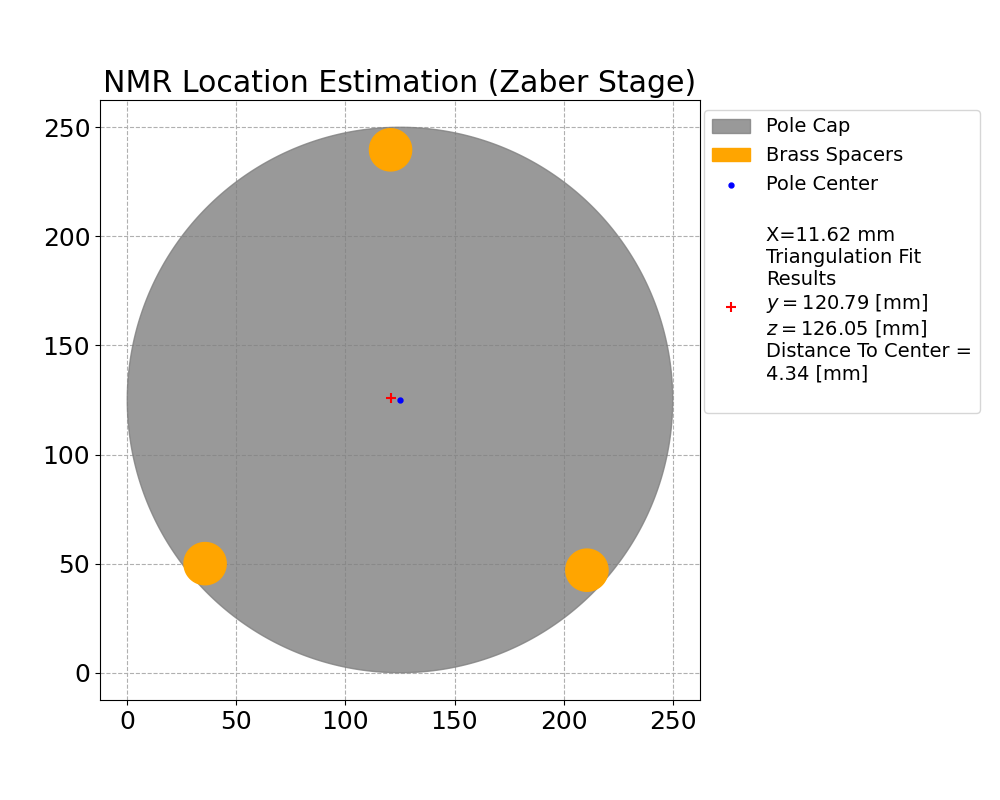

In [83]:
fig, ax, ts = make_pole_plot(stations)

#ax.plot(ys, zs, label='Pole Cap', zorder=50)
# ax.fill(ys, zs, label='Pole Cap', color='gray', alpha=0.8, zorder=50)

ax.scatter([125.], [125.], s=50, marker='.', color='blue', label='Pole Center', zorder=52)

for i, sta in enumerate(stations):
    y_ = sta[0] + spacer_diameter/2 * np.cos(ts)
    z_ = sta[1] + spacer_diameter/2 * np.sin(ts)
    l = None
    if i == 0:
        l = 'Brass Spacers'
    ax.fill(y_, z_, label=l, color='orange', zorder=51)
#ax.scatter(*stations.T, s=25, c='orange', label='Brass Spacers')
center = np.array([125., 125.])
d_xf = np.linalg.norm(nmr_best_fit_xf-center)
d_x0 = np.linalg.norm(nmr_best_fit_x0-center)

ax.scatter([nmr_best_fit_x0[0]], [nmr_best_fit_x0[1]], c='red', marker='+', s=50, zorder=53,
           label='\nX=11.62 mm\nTriangulation Fit\nResults\n'+rf'$y={nmr_best_fit_x0[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_best_fit_x0[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_x0:0.2f} [mm]\n')

ax.scatter([nmr_best_fit_xf[0]], [nmr_best_fit_xf[1]], c='cyan', marker='x', s=50, zorder=53,
           label='\nX=63.51 mm\nTriangulation Fit\nResults\n'+rf'$y={nmr_best_fit_xf[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_best_fit_xf[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_xf:0.2f} [mm]\n')
           
ax.set_title('NMR Location Estimation (Zaber Stage)')
ax.set_aspect('equal')
ax.legend(fontsize=14, bbox_to_anchor=(0.99,1.0), loc="upper left").set_zorder(100);
#ax2.legend(fontsize=14,).set_zorder(100) #bbox_to_anchor=(0.75,1.0), loc="upper left").set_zorder(100);
# fig.savefig('NMR_loc.pdf', transparent=False)
# fig.savefig('NMR_loc.png', transparent=False)

# OLD (to go through)

In [44]:
ts = np.linspace(0, 2*np.pi, 501)
ys = 125. + 125.*np.cos(ts)
zs = 125. + 125.*np.sin(ts)

In [46]:
nmr_best_fit = fit_point

<IPython.core.display.Javascript object>


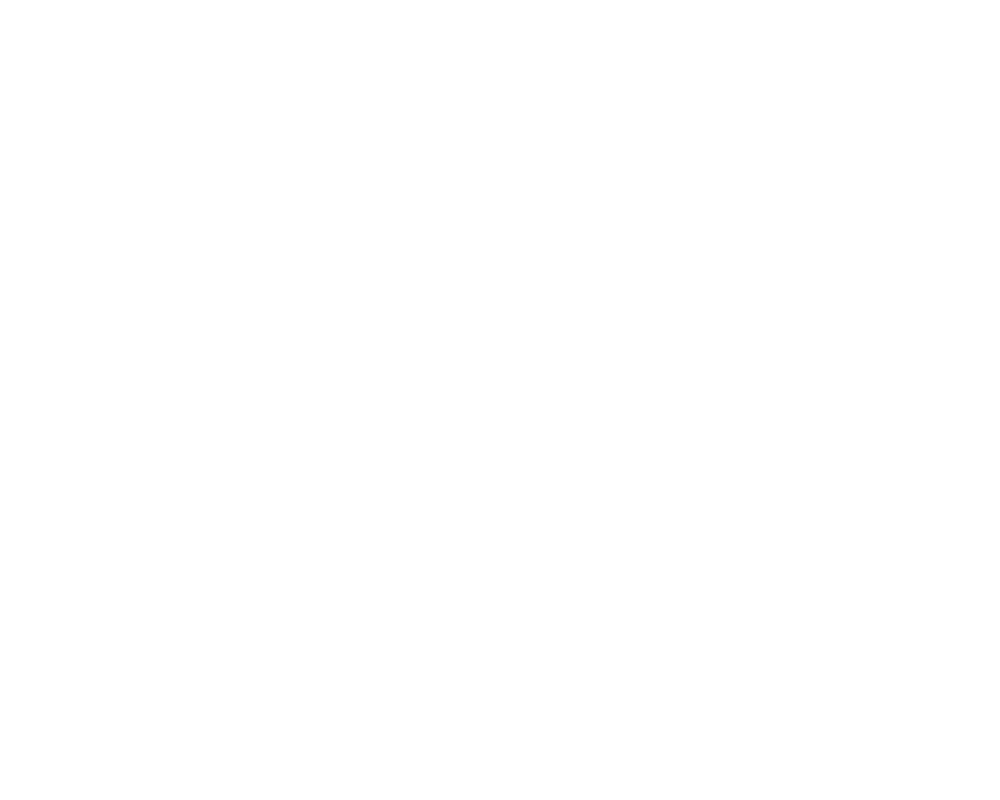

In [47]:
#fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_axes((0.1, 0.1, 0.6, 0.8))
#ax2 = fig.add_axes((0.72, 0.08, 0.25, 0.8))

#ax.plot(ys, zs, label='Pole Cap', zorder=50)
ax.fill(ys, zs, label='Pole Cap', color='gray', alpha=0.8, zorder=50)

ax.scatter([125.], [125.], s=50, marker='.', color='blue', label='Pole Center', zorder=52)

for i, sta in enumerate(stations):
    y_ = sta[0] + spacer_diameter/2 * np.cos(ts)
    z_ = sta[1] + spacer_diameter/2 * np.sin(ts)
    l = None
    if i == 0:
        l = 'Brass Spacers'
    ax.fill(y_, z_, label=l, color='orange', zorder=51)
#ax.scatter(*stations.T, s=25, c='orange', label='Brass Spacers')
center = np.array([125., 125.])
d_est = np.linalg.norm(nmr_tape_est-center)
d_fit = np.linalg.norm(nmr_best_fit-center)

ax.scatter([nmr_tape_est[0]], [nmr_tape_est[1]], c='red', marker='+', s=50, zorder=53,
           label='\nQuick Tape\nMeasurement ("Eyeballed")\n'+rf'$y={nmr_tape_est[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_tape_est[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_est:0.2f} [mm]\n')
ax.scatter([nmr_best_fit[0]], [nmr_best_fit[1]], c='green', marker='+', s=50, zorder=54,
           label='\nTriangulation Fit\nResults\n'+rf'$y={nmr_best_fit[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_fit:0.2f} [mm]\n')


ax.set_xlabel('y [mm]')
ax.set_ylabel('z [mm]')
ax.set_title('NMR Location Estimation')
ax.set_aspect('equal')
ax.legend(fontsize=14, bbox_to_anchor=(0.99,1.0), loc="upper left").set_zorder(100);
#ax2.legend(fontsize=14,).set_zorder(100) #bbox_to_anchor=(0.75,1.0), loc="upper left").set_zorder(100);
fig.savefig('NMR_loc.pdf', transparent=False)
fig.savefig('NMR_loc.png', transparent=False)

In [74]:
stations

array([[ 35.665,  50.   ],
       [120.665, 239.665],
       [210.665,  47.   ]])

In [73]:
meas_dists

array([119.415, 102.975, 127.235])

In [ ]:
fit_point, result, station_meas, station_meas_noise

In [72]:
_ = triangulate_GMW_2d_data(meas_dists, stations, init_vals=[125., 125.], noise_level=1.5875)
fit_point, result, station_meas, staion_meas_noise = _

ValueError: operands could not be broadcast together with shapes (3,) (5,) 

In [75]:
#stations = np.array([[-1, -1, -1],[1, 1, 1],[-1, 1, 1],[1, -1, -1]])
#stations = np.array([[-1, -1, -1],[1, 1, 1],[-1, 1, 1],[1, -1, 1]])

# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0]])
# stations2 = np.array([[-37.5, 0, 125.0], [-37.5, -125.0, 0], [-37.5, 0, -125.0], [-37.5, 125.0, 0],])

stations = np.array([[37.5, 0, 250.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 200.0, 0]])


#stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0], [-37.5, 0, 125.0]])
# stations = np.array([[37.5, 0, -125.0], [37.5, 125.0, 0], [-37.5, 0, 125.0], [37.5, -125.0, 0]])
# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0], [37.5, 88.4, 88.4]])
# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0],
#                      [-37.5, 88.4, 88.4], [-37.5, 88.4, -88.4], [-37.5, -88.4, -88.4], [-37.5, -88.4, 88.4],])
# stations = np.array([[37.5, 0, 125.0], [37.5, -125.0, 0], [37.5, 0, -125.0], [37.5, 125.0, 0],
#                      [-37.5, 0, 125.0], [-37.5, -125.0, 0], [-37.5, 0, -125.0], [-37.5, 125.0, 0],
#                      [-37.5, 88.4, 88.4], [-37.5, 88.4, -88.4], [-37.5, -88.4, -88.4], [-37.5, -88.4, 88.4],
#                      [37.5, 88.4, 88.4], [37.5, 88.4, -88.4], [37.5, -88.4, -88.4], [37.5, -88.4, 88.4],
#                      [0, 88.4, 88.4]
#                     ])

# Day 2

## Second Set of Measurements for NMR
- Marked with an "x" the location of the NMR sample within the probe head (4 mm from end). Repeated micrometer and "quick" estimate with careful location of NMR

In [93]:
spacer_diameter = 19.33 # mm, measured with micrometer
y_offset = 25 # mm, width of 80/2, tape measure
#spacers = np.array([
# all station units mm
stations = np.array([
    [51. + spacer_diameter/2 - y_offset, 50.],
    [136. + spacer_diameter/2 - y_offset, 230. + spacer_diameter/2],
    [226. + spacer_diameter/2 - y_offset, 47.]
    #[222. + spacer_diameter/2 - y_offset, 47.] # correction from tape
    #[223. + spacer_diameter/2 - y_offset, 47.] # correction from tape
])

meas_dists = np.array([112.78, 93.92, 112.69]) + spacer_diameter/2 # mm, measured with micrometer

nmr_tape_est = np.array([125., 135.]) # maybe 135.5
# nmr_tape_est = np.array([125., 135.5]) # maybe 135.5

In [94]:
meas_dists

array([122.445, 103.585, 122.355])

In [95]:
stations

array([[ 35.665,  50.   ],
       [120.665, 239.665],
       [210.665,  47.   ]])

In [96]:
params = {'y0':125., 'z0':125.}

In [97]:
loc2dist_2d(stations, **params)

array([116.64365489, 114.74691477, 115.85547991])

In [98]:
model = lm.Model(loc2dist_2d, independent_vars=['stations'])
params = lm.Parameters()
params.add('y0', value=125., vary=True, min=0, max=250.)
params.add('z0', value=125., vary=True, min=0, max=250.)
result = model.fit(meas_dists, stations=stations, params=params)
nmr_best_fit = np.array([result.params[f'{i}0'].value for i in ['y', 'z']])

In [99]:
result

In [100]:
ts = np.linspace(0, 2*np.pi, 501)
ys = 125. + 125.*np.cos(ts)
zs = 125. + 125.*np.sin(ts)

<IPython.core.display.Javascript object>


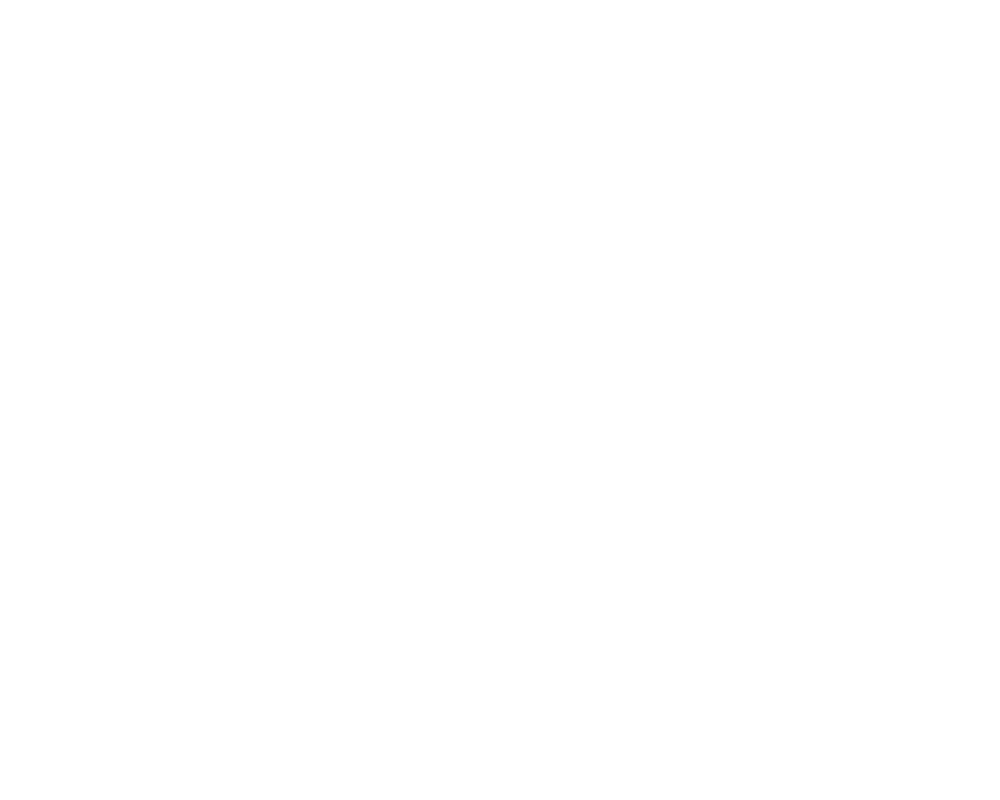

In [101]:
#fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_axes((0.1, 0.1, 0.6, 0.8))
#ax2 = fig.add_axes((0.72, 0.08, 0.25, 0.8))

#ax.plot(ys, zs, label='Pole Cap', zorder=50)
ax.fill(ys, zs, label='Pole Cap', color='gray', alpha=0.8, zorder=50)

ax.scatter([125.], [125.], s=50, marker='.', color='blue', label='Pole Center', zorder=52)

for i, sta in enumerate(stations):
    y_ = sta[0] + spacer_diameter/2 * np.cos(ts)
    z_ = sta[1] + spacer_diameter/2 * np.sin(ts)
    l = None
    if i == 0:
        l = 'Brass Spacers'
    ax.fill(y_, z_, label=l, color='orange', zorder=51)
#ax.scatter(*stations.T, s=25, c='orange', label='Brass Spacers')
center = np.array([125., 125.])
d_est = np.linalg.norm(nmr_tape_est-center)
d_fit = np.linalg.norm(nmr_best_fit-center)

ax.scatter([nmr_tape_est[0]], [nmr_tape_est[1]], c='red', marker='+', s=50, zorder=53,
           label='\nQuick Tape\nMeasurement ("Eyeballed")\n'+rf'$y={nmr_tape_est[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_tape_est[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_est:0.2f} [mm]\n')
ax.scatter([nmr_best_fit[0]], [nmr_best_fit[1]], c='green', marker='+', s=50, zorder=54,
           label='\nTriangulation Fit\nResults\n'+rf'$y={nmr_best_fit[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_fit:0.2f} [mm]\n')


ax.set_xlabel('y [mm]')
ax.set_ylabel('z [mm]')
ax.set_title('NMR Location Estimation')
ax.set_aspect('equal')
ax.legend(fontsize=14, bbox_to_anchor=(0.99,1.0), loc="upper left").set_zorder(100);
#ax2.legend(fontsize=14,).set_zorder(100) #bbox_to_anchor=(0.75,1.0), loc="upper left").set_zorder(100);
fig.savefig('NMR_loc_2.pdf', transparent=False)
fig.savefig('NMR_loc_2.png', transparent=False)

## Hall Probe Measurements
- Marked with an "+" the location of the Hall element behind the protective cover
- Measured distance from pole (with NMR) to Hall probe cover
- Measured distance from Hall probe cover to Hall element
- Using Hall probe cover plane (marked on each brass spacer), measured 2D distance Hall probe to brass spacer.
- Can use same 2D triangulation + add 3rd dimension measurement.

In [102]:
nmr_tape_est, nmr_best_fit

(array([125., 135.]), array([124.65620346, 135.11584042]))

In [104]:
# use the same as for NMR
'''
spacer_diameter = 19.33 # mm, measured with micrometer
y_offset = 25 # mm, width of 80/2, tape measure
#spacers = np.array([
# all station units mm
stations = np.array([
    [51. + spacer_diameter/2 - y_offset, 50.],
    [136. + spacer_diameter/2 - y_offset, 230. + spacer_diameter/2],
    [226. + spacer_diameter/2 - y_offset, 47.]
    #[222. + spacer_diameter/2 - y_offset, 47.] # correction from tape
    #[223. + spacer_diameter/2 - y_offset, 47.] # correction from tape
])
'''

meas_dists = np.array([97.51, 112.07, 105.82]) + spacer_diameter/2 # mm, measured with micrometer

# nmr_tape_est = np.array([125., 135.]) # maybe 135.5
# nmr_tape_est = np.array([125., 135.5]) # maybe 135.5

x0_hall = 30.60 # mm
x_offset_hall = 4.0 # mm

x_hall = x0_hall + x_offset_hall

In [105]:
meas_dists

array([107.175, 121.735, 115.485])

In [106]:
stations

array([[ 35.665,  50.   ],
       [120.665, 239.665],
       [210.665,  47.   ]])

In [107]:
model = lm.Model(loc2dist_2d, independent_vars=['stations'])
params = lm.Parameters()
params.add('y0', value=125., vary=True, min=0, max=250.)
params.add('z0', value=125., vary=True, min=0, max=250.)
result = model.fit(meas_dists, stations=stations, params=params)
hall_best_fit = np.array([result.params[f'{i}0'].value for i in ['y', 'z']])

In [108]:
result

In [109]:
ts = np.linspace(0, 2*np.pi, 501)
ys = 125. + 125.*np.cos(ts)
zs = 125. + 125.*np.sin(ts)

<IPython.core.display.Javascript object>


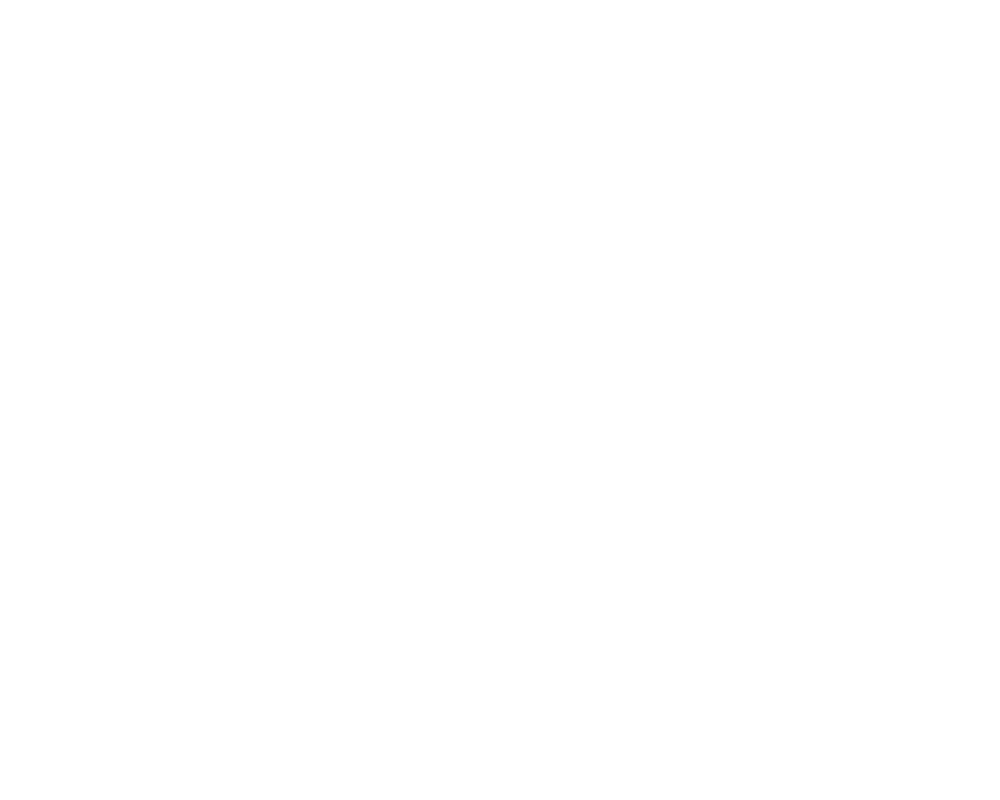

In [110]:
#fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_axes((0.1, 0.1, 0.6, 0.8))
#ax2 = fig.add_axes((0.72, 0.08, 0.25, 0.8))

#ax.plot(ys, zs, label='Pole Cap', zorder=50)
ax.fill(ys, zs, label='Pole Cap', color='gray', alpha=0.8, zorder=50)

ax.scatter([125.], [125.], s=50, marker='.', color='blue', label='Pole Center', zorder=52)

for i, sta in enumerate(stations):
    y_ = sta[0] + spacer_diameter/2 * np.cos(ts)
    z_ = sta[1] + spacer_diameter/2 * np.sin(ts)
    l = None
    if i == 0:
        l = 'Brass Spacers'
    ax.fill(y_, z_, label=l, color='orange', zorder=51)
#ax.scatter(*stations.T, s=25, c='orange', label='Brass Spacers')
center = np.array([125., 125.])
d_est = np.linalg.norm(nmr_tape_est-center)
d_fit = np.linalg.norm(nmr_best_fit-center)
d_hall = np.linalg.norm(hall_best_fit-center)

ax.scatter([nmr_tape_est[0]], [nmr_tape_est[1]], c='red', marker='+', s=50, zorder=53,
           label='\nNMR Probe\nQuick Tape\nMeasurement ("Eyeballed")\n'+rf'$y={nmr_tape_est[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_tape_est[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_est:0.2f} [mm]\n')
ax.scatter([nmr_best_fit[0]], [nmr_best_fit[1]], c='green', marker='+', s=50, zorder=54,
           label='\nNMR Probe\nTriangulation Fit\nResults\n'+rf'$y={nmr_best_fit[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_fit:0.2f} [mm]\n')

ax.scatter([hall_best_fit[0]], [hall_best_fit[1]], c='purple', marker='+', s=75, zorder=55,
           label='\nHall Probe\nTriangulation Fit\nResults\n'+rf'$y={hall_best_fit[0]:0.2f}$'+' [mm]\n'+
           rf'$z={hall_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_hall:0.2f} [mm]\n'+
           'Caliper Measurement:\n'+rf'$x = {x_hall:0.2f}$ [mm]'+'\n'
          )


ax.set_xlabel('y [mm]')
ax.set_ylabel('z [mm]')
ax.set_title('Hall and NMR Location Estimation')
ax.set_aspect('equal')
ax.legend(fontsize=14, bbox_to_anchor=(0.99,1.1), loc="upper left").set_zorder(100);
#ax2.legend(fontsize=14,).set_zorder(100) #bbox_to_anchor=(0.75,1.0), loc="upper left").set_zorder(100);
fig.savefig('Hall_and_NMR_loc_2.pdf', transparent=False)
fig.savefig('Hall_and_NMR_loc_2.png', transparent=False)

In [111]:
hall_best_fit-center

array([-5.94052964, -7.32896923])

In [112]:
37.50-34.60

2.8999999999999986

## Zaber Pole-to-Pole Measurement 06-14-21
- Measured distance to NMR sample on Zaber arm at the starting position of the pole-to-pole measurments. The aim was to put the NMR along the center of the magnet poles.

## Before Correction

In [113]:
x_offset_zaber = 12.9 - 2 + 2 # mm, Al width - NMR sample depth + Al distance from pole at start position

In [114]:
nmr_tape_est, nmr_best_fit

(array([125., 135.]), array([124.65620346, 135.11584042]))

In [115]:
# use the same as for NMR
'''
spacer_diameter = 19.33 # mm, measured with micrometer
y_offset = 25 # mm, width of 80/2, tape measure
#spacers = np.array([
# all station units mm
stations = np.array([
    [51. + spacer_diameter/2 - y_offset, 50.],
    [136. + spacer_diameter/2 - y_offset, 230. + spacer_diameter/2],
    [226. + spacer_diameter/2 - y_offset, 47.]
    #[222. + spacer_diameter/2 - y_offset, 47.] # correction from tape
    #[223. + spacer_diameter/2 - y_offset, 47.] # correction from tape
])
'''

#meas_dists = np.array([97.51, 112.07, 105.82]) + spacer_diameter/2 # mm, measured with micrometer
meas_dists = np.array([99.92, 100.17, 126.74]) + spacer_diameter/2 # mm, measured with micrometer
# TEST!!!
#meas_dists = np.array([99.92, 100.17, 110.74]) + spacer_diameter/2 # mm, measured with micrometer
# NEW LOCATION
#meas_dists = np.array([106.7, 106.05, 106.54]) + spacer_diameter/2 # mm, measured with micrometer

# nmr_tape_est = np.array([125., 135.]) # maybe 135.5
# nmr_tape_est = np.array([125., 135.5]) # maybe 135.5

x0_zaber = 12.9 - 2 + 2 # mm, Al width - NMR sample depth + Al distance from pole at start position
x_offset_zaber = 0.
#x_offset_hall = 4.0 # mm

x_zaber = x0_zaber + x_offset_zaber

In [116]:
meas_dists

array([109.585, 109.835, 136.405])

In [117]:
stations

array([[ 35.665,  50.   ],
       [120.665, 239.665],
       [210.665,  47.   ]])

In [118]:
model = lm.Model(loc2dist_2d, independent_vars=['stations'])
params = lm.Parameters()
params.add('y0', value=125., vary=True, min=0, max=250.)
params.add('z0', value=125., vary=True, min=0, max=250.)
result = model.fit(meas_dists, stations=stations, params=params)
zaber_best_fit = np.array([result.params[f'{i}0'].value for i in ['y', 'z']])

In [119]:
result

In [120]:
ts = np.linspace(0, 2*np.pi, 501)
ys = 125. + 125.*np.cos(ts)
zs = 125. + 125.*np.sin(ts)

<IPython.core.display.Javascript object>


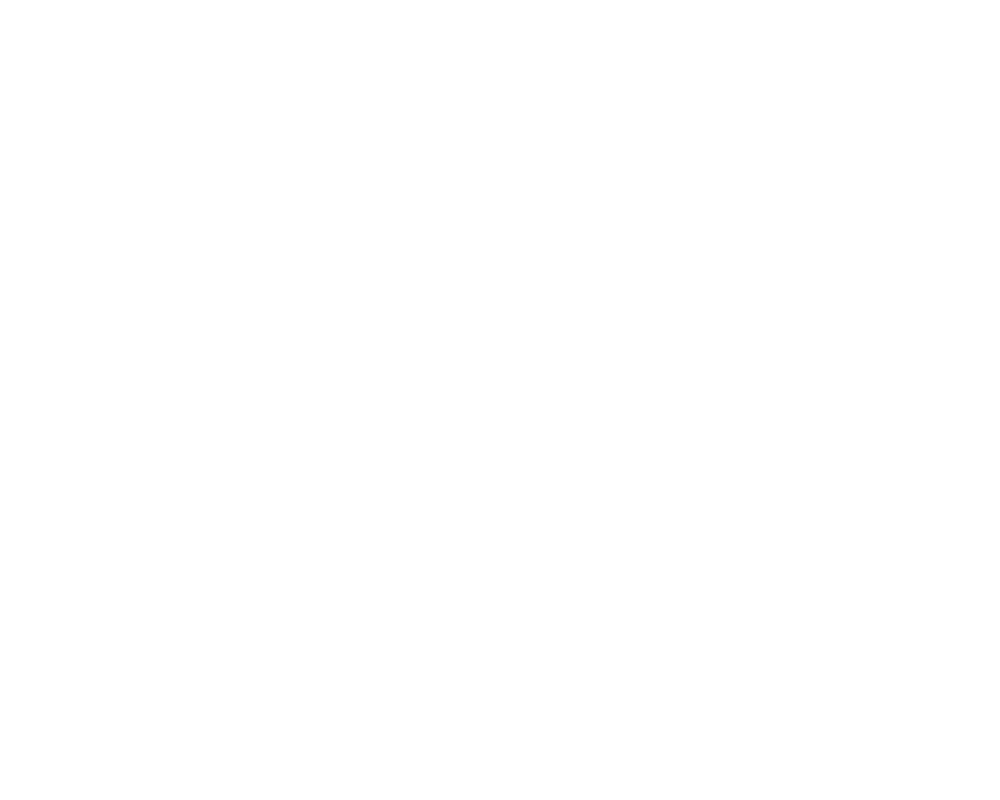

In [121]:
#fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_axes((0.1, 0.1, 0.6, 0.8))
#ax2 = fig.add_axes((0.72, 0.08, 0.25, 0.8))

#ax.plot(ys, zs, label='Pole Cap', zorder=50)
ax.fill(ys, zs, label='Pole Cap', color='gray', alpha=0.8, zorder=50)

ax.scatter([125.], [125.], s=50, marker='.', color='blue', label='Pole Center', zorder=52)

for i, sta in enumerate(stations):
    y_ = sta[0] + spacer_diameter/2 * np.cos(ts)
    z_ = sta[1] + spacer_diameter/2 * np.sin(ts)
    l = None
    if i == 0:
        l = 'Brass Spacers'
    ax.fill(y_, z_, label=l, color='orange', zorder=51)
#ax.scatter(*stations.T, s=25, c='orange', label='Brass Spacers')
center = np.array([125., 125.])
d_est = np.linalg.norm(nmr_tape_est-center)
d_fit = np.linalg.norm(nmr_best_fit-center)
d_hall = np.linalg.norm(hall_best_fit-center)
d_zaber = np.linalg.norm(zaber_best_fit-center)

ax.scatter([nmr_tape_est[0]], [nmr_tape_est[1]], c='red', marker='+', s=50, zorder=53,
           label='\nNMR Probe\nQuick Tape\nMeasurement ("Eyeballed")\n'+rf'$y={nmr_tape_est[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_tape_est[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_est:0.2f} [mm]\n')
ax.scatter([nmr_best_fit[0]], [nmr_best_fit[1]], c='green', marker='+', s=50, zorder=54,
           label='\nNMR Probe\nTriangulation Fit\nResults\n'+rf'$y={nmr_best_fit[0]:0.2f}$'+' [mm]\n'+
          rf'$z={nmr_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_fit:0.2f} [mm]\n')

ax.scatter([hall_best_fit[0]], [hall_best_fit[1]], c='purple', marker='+', s=75, zorder=55,
           label='\nHall Probe\nTriangulation Fit\nResults\n'+rf'$y={hall_best_fit[0]:0.2f}$'+' [mm]\n'+
           rf'$z={hall_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_hall:0.2f} [mm]\n'+
           'Caliper Measurement:\n'+rf'$x = {x_hall:0.2f}$ [mm]'+'\n'
          )

ax.scatter([zaber_best_fit[0]], [zaber_best_fit[1]], c='cyan', marker='+', s=75, zorder=56,
           label='\nZaber (NMR)\nTriangulation Fit\nResults\n'+rf'$y={zaber_best_fit[0]:0.2f}$'+' [mm]\n'+
           rf'$z={zaber_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_zaber:0.2f} [mm]\n'+
           'Caliper Measurement:\n'+rf'$x = {x_zaber:0.2f}$ [mm]'+'\n'
          )



ax.set_xlabel('y [mm]')
ax.set_ylabel('z [mm]')
ax.set_title('Hall and NMR Location Estimation')
ax.set_aspect('equal')
ax.legend(fontsize=12, bbox_to_anchor=(0.99,1.2), loc="upper left").set_zorder(100);
#ax2.legend(fontsize=14,).set_zorder(100) #bbox_to_anchor=(0.75,1.0), loc="upper left").set_zorder(100);
fig.savefig('Zaber_Hall_and_NMR_loc.pdf', transparent=False)
fig.savefig('Zaber_Hall_and_NMR_loc.png', transparent=False)

In [122]:
params

name,value,initial value,min,max,vary
y0,125.000000,125.0,0.00000000,250.000000,True
z0,125.000000,125.0,0.00000000,250.000000,True


In [123]:
loc2dist_2d(stations, **params)

array([116.64365489, 114.74691477, 115.85547991])

In [124]:
spacer_diameter/2

9.665

In [125]:
loc2dist_2d(stations, **params) - spacer_diameter/2

array([106.97865489, 105.08191477, 106.19047991])

In [126]:
hall_best_fit-center

array([-5.94052964, -7.32896923])

In [127]:
37.50-34.60

2.8999999999999986

In [128]:
zaber_best_fit - center

array([-19.44030872,   7.5487294 ])

In [129]:
y0 = 460000; z0 = 1689210 # ADC
y0mm = 160; z0mm = 100 # mm

In [130]:
yf = 366402; zf = 1629710 # ADC
yfmm = 125; zfmm = 125; # mm

In [131]:
ADC_per_mm = 2560.0

In [132]:
(yf-y0) / ADC_per_mm

-36.56171875

In [133]:
(zf-z0) / ADC_per_mm

-23.2421875

In [134]:
dy, dz = (zaber_best_fit - center) * ADC_per_mm # ADC

In [135]:
dy, dz

(-49767.190317343266, 19324.747256598566)

In [136]:
ynew = round(yf - dy)
ynew

416169

In [137]:
yf

366402

In [138]:
znew = round(zf + dz)
znew

1649035

In [139]:
# 3D grid (2 mm step)

In [140]:
25600 / 5

5120.0

In [141]:
ADC_per_mm * 2

5120.0

In [142]:
ynew - ADC_per_mm*5

403369.0

In [143]:
znew - ADC_per_mm*5

1636235.0

In [144]:
ADC_per_mm*10

25600.0

## After Correction

In [145]:
x_offset_zaber = 12.9 - 2 + 2 # mm, Al width - NMR sample depth + Al distance from pole at start position

In [146]:
nmr_tape_est, nmr_best_fit

(array([125., 135.]), array([124.65620346, 135.11584042]))

In [147]:
# use the same as for NMR
'''
spacer_diameter = 19.33 # mm, measured with micrometer
y_offset = 25 # mm, width of 80/2, tape measure
#spacers = np.array([
# all station units mm
stations = np.array([
    [51. + spacer_diameter/2 - y_offset, 50.],
    [136. + spacer_diameter/2 - y_offset, 230. + spacer_diameter/2],
    [226. + spacer_diameter/2 - y_offset, 47.]
    #[222. + spacer_diameter/2 - y_offset, 47.] # correction from tape
    #[223. + spacer_diameter/2 - y_offset, 47.] # correction from tape
])
'''

#meas_dists = np.array([97.51, 112.07, 105.82]) + spacer_diameter/2 # mm, measured with micrometer
#meas_dists = np.array([99.92, 100.17, 126.74]) + spacer_diameter/2 # mm, measured with micrometer
# TEST!!!
#meas_dists = np.array([99.92, 100.17, 110.74]) + spacer_diameter/2 # mm, measured with micrometer
# NEW LOCATION
meas_dists = np.array([106.7, 106.05, 106.54]) + spacer_diameter/2 # mm, measured with micrometer
# second measurement after 3D scan
meas_dists2 = np.array([106.84, 106.00, 106.92]) + spacer_diameter/2 # mm, measured with micrometer

# nmr_tape_est = np.array([125., 135.]) # maybe 135.5
# nmr_tape_est = np.array([125., 135.5]) # maybe 135.5

x0_zaber = 12.9 - 2 + 2 # mm, Al width - NMR sample depth + Al distance from pole at start position
x_offset_zaber = 0.
#x_offset_hall = 4.0 # mm

x_zaber = x0_zaber + x_offset_zaber

In [148]:
meas_dists

array([116.365, 115.715, 116.205])

In [149]:
stations

array([[ 35.665,  50.   ],
       [120.665, 239.665],
       [210.665,  47.   ]])

In [150]:
model = lm.Model(loc2dist_2d, independent_vars=['stations'])
params = lm.Parameters()
params.add('y0', value=125., vary=True, min=0, max=250.)
params.add('z0', value=125., vary=True, min=0, max=250.)
result = model.fit(meas_dists, stations=stations, params=params)
zaber_best_fit_corr = np.array([result.params[f'{i}0'].value for i in ['y', 'z']])
result2 = model.fit(meas_dists2, stations=stations, params=params)
zaber_best_fit_corr2 = np.array([result2.params[f'{i}0'].value for i in ['y', 'z']])

In [151]:
result

In [152]:
result2

In [153]:
ts = np.linspace(0, 2*np.pi, 501)
ys = 125. + 125.*np.cos(ts)
zs = 125. + 125.*np.sin(ts)

<IPython.core.display.Javascript object>


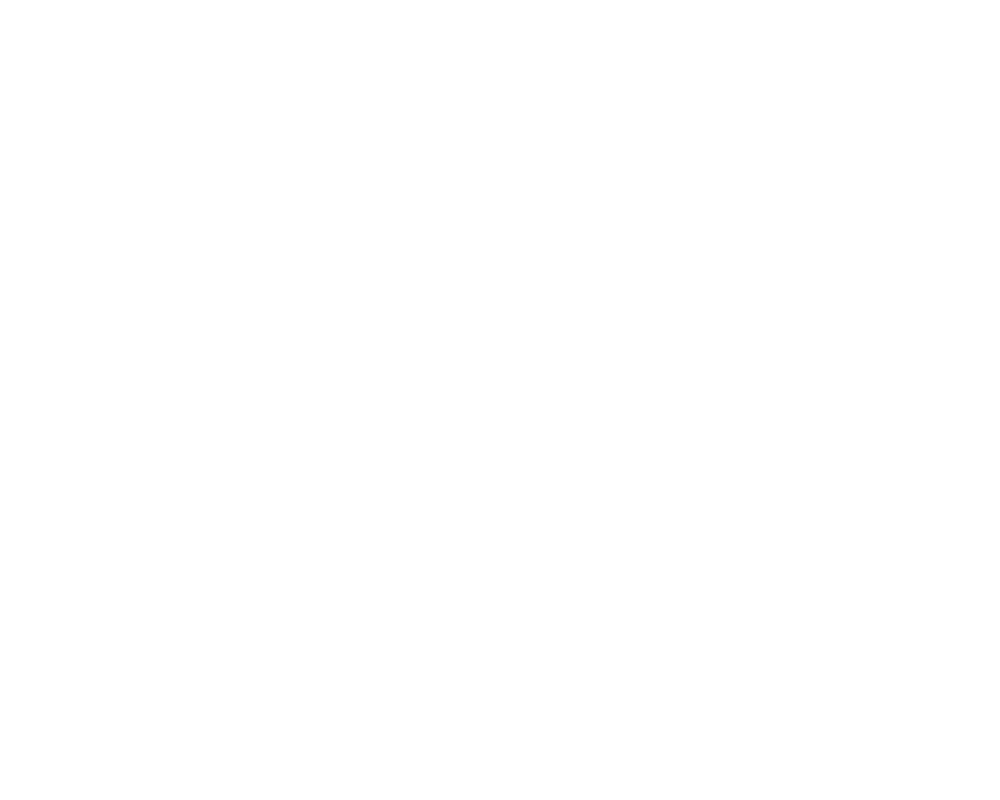

In [154]:
#fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_axes((0.1, 0.1, 0.6, 0.8))
#ax2 = fig.add_axes((0.72, 0.08, 0.25, 0.8))

#ax.plot(ys, zs, label='Pole Cap', zorder=50)
ax.fill(ys, zs, label='Pole Cap', color='gray', alpha=0.8, zorder=50)

ax.scatter([125.], [125.], s=50, marker='.', color='blue', label='Pole Center', zorder=52)

for i, sta in enumerate(stations):
    y_ = sta[0] + spacer_diameter/2 * np.cos(ts)
    z_ = sta[1] + spacer_diameter/2 * np.sin(ts)
    l = None
    if i == 0:
        l = 'Brass Spacers'
    ax.fill(y_, z_, label=l, color='orange', zorder=51)
#ax.scatter(*stations.T, s=25, c='orange', label='Brass Spacers')
center = np.array([125., 125.])
d_est = np.linalg.norm(nmr_tape_est-center)
d_fit = np.linalg.norm(nmr_best_fit-center)
d_hall = np.linalg.norm(hall_best_fit-center)
d_zaber = np.linalg.norm(zaber_best_fit-center)
d_zaber_corr = np.linalg.norm(zaber_best_fit_corr-center)
d_zaber_corr2 = np.linalg.norm(zaber_best_fit_corr2-center)

# ax.scatter([nmr_tape_est[0]], [nmr_tape_est[1]], c='red', marker='+', s=50, zorder=53,
#            label='\nNMR Probe\nQuick Tape\nMeasurement ("Eyeballed")\n'+rf'$y={nmr_tape_est[0]:0.2f}$'+' [mm]\n'+
#           rf'$z={nmr_tape_est[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_est:0.2f} [mm]\n')
# ax.scatter([nmr_best_fit[0]], [nmr_best_fit[1]], c='green', marker='+', s=50, zorder=54,
#            label='\nNMR Probe\nTriangulation Fit\nResults\n'+rf'$y={nmr_best_fit[0]:0.2f}$'+' [mm]\n'+
#           rf'$z={nmr_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_fit:0.2f} [mm]\n')

# ax.scatter([hall_best_fit[0]], [hall_best_fit[1]], c='purple', marker='+', s=75, zorder=55,
#            label='\nHall Probe\nTriangulation Fit\nResults\n'+rf'$y={hall_best_fit[0]:0.2f}$'+' [mm]\n'+
#            rf'$z={hall_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_hall:0.2f} [mm]\n'+
#            'Caliper Measurement:\n'+rf'$x = {x_hall:0.2f}$ [mm]'+'\n'
#           )

# ax.scatter([zaber_best_fit[0]], [zaber_best_fit[1]], c='cyan', marker='+', s=75, zorder=56,
#            label='\nZaber (NMR)\nTriangulation Fit\nResults\n'+rf'$y={zaber_best_fit[0]:0.2f}$'+' [mm]\n'+
#            rf'$z={zaber_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_zaber:0.2f} [mm]\n'+
#            'Caliper Measurement:\n'+rf'$x = {x_zaber:0.2f}$ [mm]'+'\n'
#           )

# corrected position
# first measurement
ax.scatter([zaber_best_fit_corr[0]], [zaber_best_fit_corr[1]], c='magenta', marker='+', s=75, zorder=56,
           label='\nZaber (NMR)\nTriangulation Fit\nResults\n(Before 3D Grid)\n'+rf'$y={zaber_best_fit_corr[0]:0.2f}$'+' [mm]\n'+
           rf'$z={zaber_best_fit_corr[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_zaber_corr:0.2f} [mm]\n'+
           'Caliper Measurement:\n'+rf'$x = {x_zaber:0.2f}$ [mm]'+'\n'
          )

# 2nd measurement
ax.scatter([zaber_best_fit_corr2[0]], [zaber_best_fit_corr2[1]], c='limegreen', marker='x', s=95, zorder=57,
           label='\nZaber (NMR)\nTriangulation Fit\nResults\n(After 3D Grid)\n'+rf'$y={zaber_best_fit_corr2[0]:0.2f}$'+' [mm]\n'+
           rf'$z={zaber_best_fit_corr2[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_zaber_corr2:0.2f} [mm]\n'+
           'Caliper Measurement:\n'+rf'$x = {x_zaber:0.2f}$ [mm]'+'\n'
          )



ax.set_xlabel('y [mm]')
ax.set_ylabel('z [mm]')
ax.set_title('NMR on Zaber Location Estimation')
ax.set_aspect('equal')
ax.legend(fontsize=12, bbox_to_anchor=(0.99,0.9), loc="upper left").set_zorder(100);
#ax2.legend(fontsize=14,).set_zorder(100) #bbox_to_anchor=(0.75,1.0), loc="upper left").set_zorder(100);
# fig.savefig('Zaber_NMR_loc_corr.pdf', transparent=False)
# fig.savefig('Zaber_NMR_loc_corr.png', transparent=False)

fig.savefig('Zaber_NMR_loc_corr_2nd_meas.pdf', transparent=False)
fig.savefig('Zaber_NMR_loc_corr_2nd_meas.png', transparent=False)

## For fun plot Measurements

In [216]:
ts = np.linspace(0, 2*np.pi, 501)
ys = 125. + 125.*np.cos(ts)
zs = 125. + 125.*np.sin(ts)

<IPython.core.display.Javascript object>


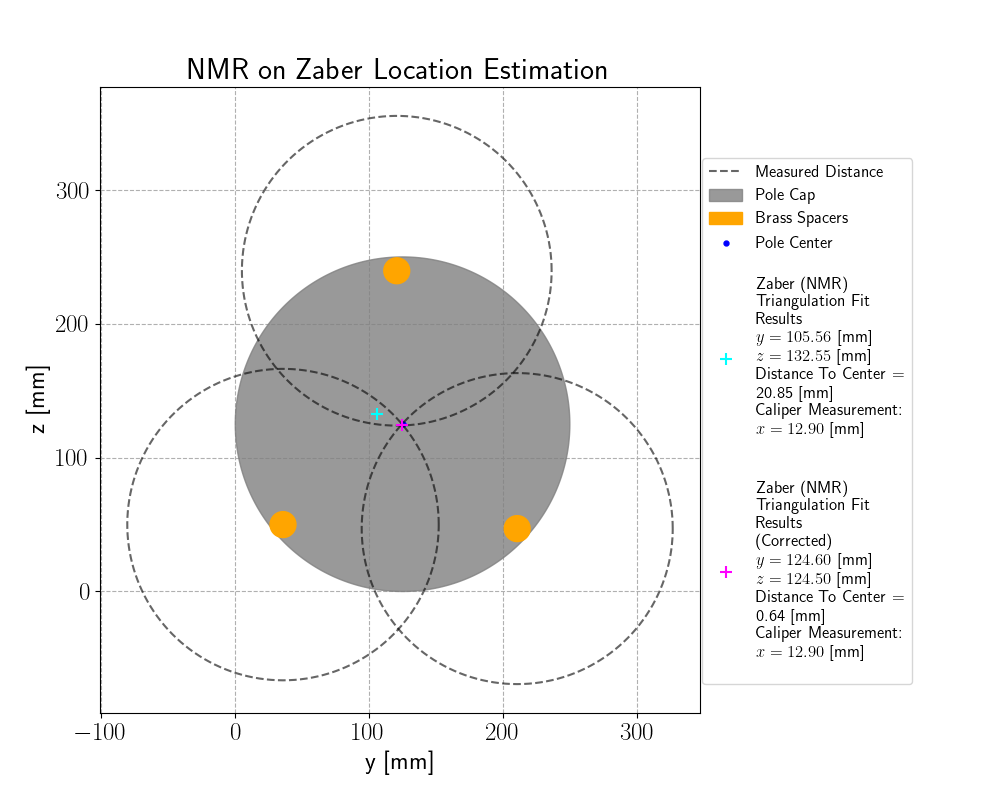

In [223]:
#fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_axes((0.1, 0.1, 0.6, 0.8))
#ax2 = fig.add_axes((0.72, 0.08, 0.25, 0.8))

#ax.plot(ys, zs, label='Pole Cap', zorder=50)
ax.fill(ys, zs, label='Pole Cap', color='gray', alpha=0.8, zorder=50)

ax.scatter([125.], [125.], s=50, marker='.', color='blue', label='Pole Center', zorder=52)

for i, _ in enumerate(zip(stations, meas_dists)):
    sta, mea = _
    y_ = sta[0] + spacer_diameter/2 * np.cos(ts)
    z_ = sta[1] + spacer_diameter/2 * np.sin(ts)
    y2_ = sta[0] + mea * np.cos(ts)
    z2_ = sta[1] + mea * np.sin(ts)
    l = None
    l2 = None
    if i == 0:
        l = 'Brass Spacers'
        l2 = 'Measured Distance'
    ax.fill(y_, z_, label=l, color='orange', zorder=51)
    ax.plot(y2_, z2_, label=l2, color='black', linestyle='--', alpha=0.6, zorder=52)
#ax.scatter(*stations.T, s=25, c='orange', label='Brass Spacers')
center = np.array([125., 125.])
d_est = np.linalg.norm(nmr_tape_est-center)
d_fit = np.linalg.norm(nmr_best_fit-center)
d_hall = np.linalg.norm(hall_best_fit-center)
d_zaber = np.linalg.norm(zaber_best_fit-center)
d_zaber_corr = np.linalg.norm(zaber_best_fit_corr-center)

# ax.scatter([nmr_tape_est[0]], [nmr_tape_est[1]], c='red', marker='+', s=50, zorder=53,
#            label='\nNMR Probe\nQuick Tape\nMeasurement ("Eyeballed")\n'+rf'$y={nmr_tape_est[0]:0.2f}$'+' [mm]\n'+
#           rf'$z={nmr_tape_est[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_est:0.2f} [mm]\n')
# ax.scatter([nmr_best_fit[0]], [nmr_best_fit[1]], c='green', marker='+', s=50, zorder=54,
#            label='\nNMR Probe\nTriangulation Fit\nResults\n'+rf'$y={nmr_best_fit[0]:0.2f}$'+' [mm]\n'+
#           rf'$z={nmr_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_fit:0.2f} [mm]\n')

# ax.scatter([hall_best_fit[0]], [hall_best_fit[1]], c='purple', marker='+', s=75, zorder=55,
#            label='\nHall Probe\nTriangulation Fit\nResults\n'+rf'$y={hall_best_fit[0]:0.2f}$'+' [mm]\n'+
#            rf'$z={hall_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_hall:0.2f} [mm]\n'+
#            'Caliper Measurement:\n'+rf'$x = {x_hall:0.2f}$ [mm]'+'\n'
#           )

ax.scatter([zaber_best_fit[0]], [zaber_best_fit[1]], c='cyan', marker='+', s=75, zorder=56,
           label='\nZaber (NMR)\nTriangulation Fit\nResults\n'+rf'$y={zaber_best_fit[0]:0.2f}$'+' [mm]\n'+
           rf'$z={zaber_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_zaber:0.2f} [mm]\n'+
           'Caliper Measurement:\n'+rf'$x = {x_zaber:0.2f}$ [mm]'+'\n'
          )

ax.scatter([zaber_best_fit_corr[0]], [zaber_best_fit_corr[1]], c='magenta', marker='+', s=75, zorder=56,
           label='\nZaber (NMR)\nTriangulation Fit\nResults\n(Corrected)\n'+rf'$y={zaber_best_fit_corr[0]:0.2f}$'+' [mm]\n'+
           rf'$z={zaber_best_fit_corr[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_zaber_corr:0.2f} [mm]\n'+
           'Caliper Measurement:\n'+rf'$x = {x_zaber:0.2f}$ [mm]'+'\n'
          )



ax.set_xlabel('y [mm]')
ax.set_ylabel('z [mm]')
ax.set_title('NMR on Zaber Location Estimation')
ax.set_aspect('equal')
ax.legend(fontsize=12, bbox_to_anchor=(0.99,0.9), loc="upper left").set_zorder(100);
#ax2.legend(fontsize=14,).set_zorder(100) #bbox_to_anchor=(0.75,1.0), loc="upper left").set_zorder(100);
fig.savefig('Zaber_NMR_loc_corr_meas.pdf', transparent=False)
fig.savefig('Zaber_NMR_loc_corr_meas.png', transparent=False)

# Triangulation along Pole-to-Pole

In [202]:
x_offset_zaber = 12.9 - 2 + 2 # mm, Al width - NMR sample depth + Al distance from pole at start position

In [203]:
nmr_tape_est, nmr_best_fit

(array([125., 135.]), array([124.65620346, 135.11584042]))

In [242]:
# x0
meas_dists = np.array([106.8, 106.58, 106.41]) + spacer_diameter/2 # mm, measured with micrometer
# xf
meas_dists2 = np.array([106.59, 102.43, 111.73]) + spacer_diameter/2 # mm, measured with micrometer

# nmr_tape_est = np.array([125., 135.]) # maybe 135.5
# nmr_tape_est = np.array([125., 135.5]) # maybe 135.5

# x0_zaber = 12.9 - 2 + 2 # mm, Al width - NMR sample depth + Al distance from pole at start position
# x_offset_zaber = 0.
#x_offset_hall = 4.0 # mm

# x_zaber = x0_zaber + x_offset_zaber

In [246]:
x_zaber = 10.9
x_zaber2 = 62.696875 - 10.

In [247]:
x_zaber, x_zaber2

(10.9, 52.696875)

In [248]:
x_zaber2 - x_zaber

41.796875

In [238]:
meas_dists

array([116.365, 115.715, 116.205])

In [239]:
stations

array([[ 35.665,  50.   ],
       [120.665, 239.665],
       [210.665,  47.   ]])

In [243]:
model = lm.Model(loc2dist_2d, independent_vars=['stations'])
params = lm.Parameters()
params.add('y0', value=125., vary=True, min=0, max=250.)
params.add('z0', value=125., vary=True, min=0, max=250.)
result = model.fit(meas_dists, stations=stations, params=params)
zaber_best_fit_corr = np.array([result.params[f'{i}0'].value for i in ['y', 'z']])
result2 = model.fit(meas_dists2, stations=stations, params=params)
zaber_best_fit_corr2 = np.array([result2.params[f'{i}0'].value for i in ['y', 'z']])

In [244]:
result

In [245]:
result2

In [250]:
zaber_best_fit_corr2 - zaber_best_fit_corr

array([-3.69906193,  3.99430658])

In [251]:
np.linalg.norm(zaber_best_fit_corr2 - zaber_best_fit_corr)

5.444037489187269

In [266]:
n1 = 5.4440
# n1 = -3.699
# n1 = 3.994

In [267]:
np.arcsin(n1 / 41.797)

0.13061969378689323

In [268]:
np.degrees(np.arcsin(n1 / 41.797))

7.483957175280163

In [258]:
np.arctan2(n1, 41.797)

0.09526783154038847

In [259]:
np.degrees(np.arctan2(n1, 41.797))

5.458444670627568

In [228]:
ts = np.linspace(0, 2*np.pi, 501)
ys = 125. + 125.*np.cos(ts)
zs = 125. + 125.*np.sin(ts)

<IPython.core.display.Javascript object>


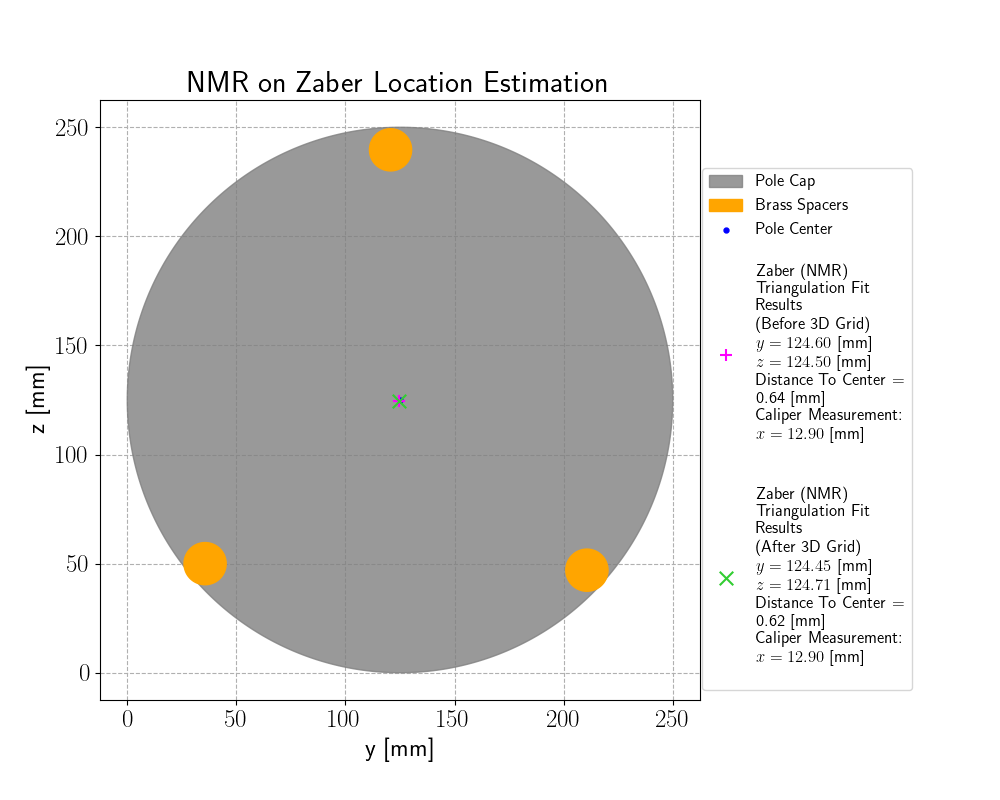

In [236]:
#fig, ax = plt.subplots()
fig = plt.figure()
ax = fig.add_axes((0.1, 0.1, 0.6, 0.8))
#ax2 = fig.add_axes((0.72, 0.08, 0.25, 0.8))

#ax.plot(ys, zs, label='Pole Cap', zorder=50)
ax.fill(ys, zs, label='Pole Cap', color='gray', alpha=0.8, zorder=50)

ax.scatter([125.], [125.], s=50, marker='.', color='blue', label='Pole Center', zorder=52)

for i, sta in enumerate(stations):
    y_ = sta[0] + spacer_diameter/2 * np.cos(ts)
    z_ = sta[1] + spacer_diameter/2 * np.sin(ts)
    l = None
    if i == 0:
        l = 'Brass Spacers'
    ax.fill(y_, z_, label=l, color='orange', zorder=51)
#ax.scatter(*stations.T, s=25, c='orange', label='Brass Spacers')
center = np.array([125., 125.])
d_est = np.linalg.norm(nmr_tape_est-center)
d_fit = np.linalg.norm(nmr_best_fit-center)
d_hall = np.linalg.norm(hall_best_fit-center)
d_zaber = np.linalg.norm(zaber_best_fit-center)
d_zaber_corr = np.linalg.norm(zaber_best_fit_corr-center)
d_zaber_corr2 = np.linalg.norm(zaber_best_fit_corr2-center)

# ax.scatter([nmr_tape_est[0]], [nmr_tape_est[1]], c='red', marker='+', s=50, zorder=53,
#            label='\nNMR Probe\nQuick Tape\nMeasurement ("Eyeballed")\n'+rf'$y={nmr_tape_est[0]:0.2f}$'+' [mm]\n'+
#           rf'$z={nmr_tape_est[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_est:0.2f} [mm]\n')
# ax.scatter([nmr_best_fit[0]], [nmr_best_fit[1]], c='green', marker='+', s=50, zorder=54,
#            label='\nNMR Probe\nTriangulation Fit\nResults\n'+rf'$y={nmr_best_fit[0]:0.2f}$'+' [mm]\n'+
#           rf'$z={nmr_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_fit:0.2f} [mm]\n')

# ax.scatter([hall_best_fit[0]], [hall_best_fit[1]], c='purple', marker='+', s=75, zorder=55,
#            label='\nHall Probe\nTriangulation Fit\nResults\n'+rf'$y={hall_best_fit[0]:0.2f}$'+' [mm]\n'+
#            rf'$z={hall_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_hall:0.2f} [mm]\n'+
#            'Caliper Measurement:\n'+rf'$x = {x_hall:0.2f}$ [mm]'+'\n'
#           )

# ax.scatter([zaber_best_fit[0]], [zaber_best_fit[1]], c='cyan', marker='+', s=75, zorder=56,
#            label='\nZaber (NMR)\nTriangulation Fit\nResults\n'+rf'$y={zaber_best_fit[0]:0.2f}$'+' [mm]\n'+
#            rf'$z={zaber_best_fit[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_zaber:0.2f} [mm]\n'+
#            'Caliper Measurement:\n'+rf'$x = {x_zaber:0.2f}$ [mm]'+'\n'
#           )

# corrected position
# first measurement
ax.scatter([zaber_best_fit_corr[0]], [zaber_best_fit_corr[1]], c='magenta', marker='+', s=75, zorder=56,
           label='\nZaber (NMR)\nTriangulation Fit\nResults\n(Before 3D Grid)\n'+rf'$y={zaber_best_fit_corr[0]:0.2f}$'+' [mm]\n'+
           rf'$z={zaber_best_fit_corr[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_zaber_corr:0.2f} [mm]\n'+
           'Caliper Measurement:\n'+rf'$x = {x_zaber:0.2f}$ [mm]'+'\n'
          )

# 2nd measurement
ax.scatter([zaber_best_fit_corr2[0]], [zaber_best_fit_corr2[1]], c='limegreen', marker='x', s=95, zorder=57,
           label='\nZaber (NMR)\nTriangulation Fit\nResults\n(After 3D Grid)\n'+rf'$y={zaber_best_fit_corr2[0]:0.2f}$'+' [mm]\n'+
           rf'$z={zaber_best_fit_corr2[1]:0.2f}$ [mm]'+'\n'+f'Distance To Center =\n{d_zaber_corr2:0.2f} [mm]\n'+
           'Caliper Measurement:\n'+rf'$x = {x_zaber:0.2f}$ [mm]'+'\n'
          )



ax.set_xlabel('y [mm]')
ax.set_ylabel('z [mm]')
ax.set_title('NMR on Zaber Location Estimation')
ax.set_aspect('equal')
ax.legend(fontsize=12, bbox_to_anchor=(0.99,0.9), loc="upper left").set_zorder(100);
#ax2.legend(fontsize=14,).set_zorder(100) #bbox_to_anchor=(0.75,1.0), loc="upper left").set_zorder(100);
# fig.savefig('Zaber_NMR_loc_corr.pdf', transparent=False)
# fig.savefig('Zaber_NMR_loc_corr.png', transparent=False)

fig.savefig('Zaber_NMR_loc_corr_2nd_meas.pdf', transparent=False)
fig.savefig('Zaber_NMR_loc_corr_2nd_meas.png', transparent=False)